<a href="https://colab.research.google.com/github/bzizmza/Time-Series/blob/main/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project - Forecasting PM2.5 Value
## by Abimanyu Sri Setyo

**Project Criteria**
* The dataset to be used is free, but has a minimum of 1000 samples.
* Must use LSTM in model architecture.
* Validation set is 20% of the total dataset.
* The model must use a sequential model.
* Must use Learning Rate on Optimizer.
* MAE < 10% data scale.

**About Dataset**
* **[Forecasting PM2.5 Value](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)**, PM2.5 is an air pollutant that is a concern for people's health when levels in air are high. This hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf

## Import Dataset

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv")
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


## Cleaning Dataset

### Dropping data with NaN value

In [3]:
df = df.dropna()
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Dropping time attributes and categorical attributes

In [4]:
df_train = df.drop(['No', 'year', 'month', 'day', 'hour', 'cbwd'], axis=1)
df_train.reset_index().drop(['index'], axis=1).head(20)

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,129.0,-16,-4.0,1020.0,1.79,0,0
1,148.0,-15,-4.0,1020.0,2.68,0,0
2,159.0,-11,-5.0,1021.0,3.57,0,0
3,181.0,-7,-5.0,1022.0,5.36,1,0
4,138.0,-7,-5.0,1022.0,6.25,2,0
5,109.0,-7,-6.0,1022.0,7.14,3,0
6,105.0,-7,-6.0,1023.0,8.93,4,0
7,124.0,-7,-5.0,1024.0,10.72,0,0
8,120.0,-8,-6.0,1024.0,12.51,0,0
9,132.0,-7,-5.0,1025.0,14.30,0,0


### Checking null value for every attributes

In [5]:
df_train.isnull().sum() 

pm2.5    0
DEWP     0
TEMP     0
PRES     0
Iws      0
Is       0
Ir       0
dtype: int64

In [6]:
df_train.describe()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,98.613215,1.750174,12.401561,1016.442896,23.866747,0.055344,0.194866
std,92.050387,14.433658,12.175215,10.300733,49.617495,0.778875,1.418165
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,565.490000,27.000000,36.000000


## Making data transformation function

In [7]:
def data2sequences(df, window_size=1):
  X = []
  y = []
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled = scaler.fit_transform(df)
  for i in range(len(df)-window_size):
    X.append(scaled[i:i+window_size])
    y.append(df['pm2.5'].iloc[i+window_size])
  
  return X, y, scaler

## Transform data into sequential data attributes with 10 consecutive days as input features

In [8]:
X, y, scaler = data2sequences(df_train, window_size=10)

## Dividing data into train and test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=False)

## Construct the model

In [10]:
model = tf.keras.models.Sequential([                                  
  tf.keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mae',
              optimizer=optimizer,
              metrics=["mae"])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10,
                                              monitor='val_loss',
                                              restore_best_weights=True)]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43200     
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 135,105
Trainable params: 135,105
Non-trainable params: 0
_________________________________________________________________


## Run the model

In [11]:
history = model.fit(X_train.astype('float32'),
                    y_train.astype('float32'), epochs=100,
                    batch_size=64,
                    validation_data=(X_test.astype('float32'),
                                     y_test.astype('float32')),
                    callbacks=callbacks)

Epoch 1/100
522/522 [==============================] - 9s 6ms/step - loss: 21.1010 - mae: 21.1010 - val_loss: 11.5925 - val_mae: 11.5925
Epoch 2/100
522/522 [==============================] - 3s 6ms/step - loss: 13.8164 - mae: 13.8164 - val_loss: 13.3774 - val_mae: 13.3774
Epoch 3/100
522/522 [==============================] - 3s 5ms/step - loss: 13.8388 - mae: 13.8388 - val_loss: 11.4672 - val_mae: 11.4672
Epoch 4/100
522/522 [==============================] - 3s 6ms/step - loss: 13.7736 - mae: 13.7736 - val_loss: 11.3667 - val_mae: 11.3667
Epoch 5/100
522/522 [==============================] - 3s 6ms/step - loss: 13.6728 - mae: 13.6728 - val_loss: 11.6960 - val_mae: 11.6960
Epoch 6/100
522/522 [==============================] - 3s 5ms/step - loss: 13.6868 - mae: 13.6868 - val_loss: 13.0270 - val_mae: 13.0270
Epoch 7/100
522/522 [==============================] - 3s 6ms/step - loss: 13.4331 - mae: 13.4331 - val_loss: 11.4661 - val_mae: 11.4661
Epoch 8/100
522/522 [====================

## Compare MAE

In [12]:
max = df_train.describe()['pm2.5']['max']
min = df_train.describe()['pm2.5']['min']

prediction = model.predict(X_train)
prediction2 = model.predict(X_test)

print('MAE Train Data : ', mean_absolute_error(y_train, prediction))
print('MAE Test Data : ', mean_absolute_error(y_test, prediction2))

MAE Train Data :  12.8005711883891
MAE Test Data :  11.366722435530074


## Visualize Data

### Plotting Actual Value of PM2.5 Data

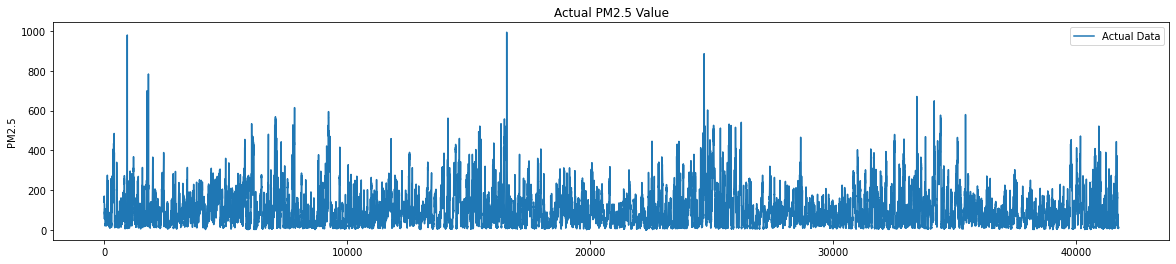

In [20]:
plt.figure(figsize=(20,4))
plt.plot(y, label = "Actual Data")
plt.title('Actual PM2.5 Value')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

### Plotting Actual vs Prediction Value of PM2.5 Data

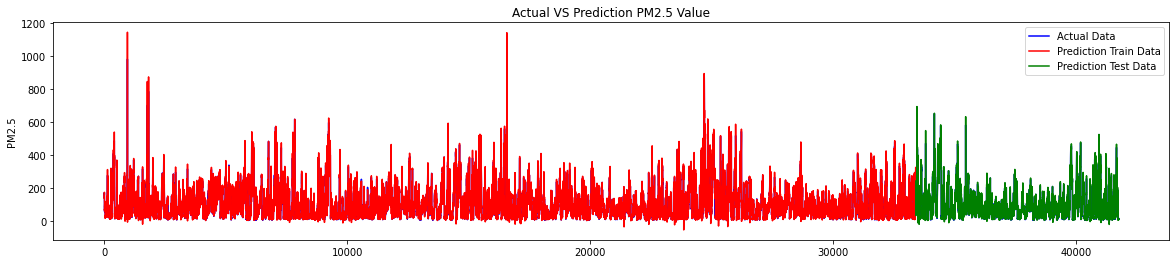

In [21]:
plt.figure(figsize=(20,4))
plt.plot(y, color='blue', label='Actual Data')
plt.plot(range(0, len(y_train)), prediction, color='red', label='Prediction Train Data')
plt.plot(range(len(y_train),len(y)), prediction2, color='green', label='Prediction Test Data')
plt.title('Actual VS Prediction PM2.5 Value')
plt.ylabel('PM2.5')
plt.legend()
plt.show()